In [62]:
# Importacion de librerias
import os
import pandas as pd
import transformers as tr
import accelerate
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay,  classification_report
from transformers import DataCollatorForTokenClassification
from transformers import AutoTokenizer, T5Tokenizer,T5ForConditionalGeneration, TrainingArguments, Trainer, DataCollatorForSeq2Seq, AutoModelForSequenceClassification
from datasets import load_dataset, load_metric
from torch.optim import AdamW

# Summarization

## FineTuning Summarizazer

In [2]:
# Descarga del dataset a utilizar para entrenamiento
text_dataset = load_dataset("yasminesarraj/texts_summary",
cache_dir= "local-datasets", trust_remote_code=True                
)
text_dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'summary'],
        num_rows: 47
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'summary'],
        num_rows: 47
    })
})

In [3]:
# Dataset que sera utilizado para resumir
medical_text = load_dataset("123rc/medical_text",
cache_dir= "local-datasets", trust_remote_code=True                
)
medical_text

DatasetDict({
    train: Dataset({
        features: ['condition_label', 'medical_abstract'],
        num_rows: 11550
    })
    test: Dataset({
        features: ['condition_label', 'medical_abstract'],
        num_rows: 2888
    })
})

In [4]:
# Configurar el modelo y el tokenizer
model_checkpoint = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(model_checkpoint, cache_dir="local-datasets")
model = T5ForConditionalGeneration.from_pretrained(model_checkpoint, cache_dir="local-datasets")

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\t5\tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you c

In [5]:
# Configurar el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [6]:
def preprocess_function(examples):
    inputs = examples['text']
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['summary'], max_length=250, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenizar el dataset
tokenized_dataset = text_dataset.map(preprocess_function, batched=True, remove_columns=['text', 'summary', 'Unnamed: 0'])

# Dividir el dataset en entrenamiento y evaluación
train_dataset = tokenized_dataset["train"]
eval_dataset = tokenized_dataset["test"]

In [7]:
# Configurar el Data Collator
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model, padding="longest")

# Configuración de los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=10_000,
    save_total_limit=2,

)

# Inicializar el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
# Entrenar el modelo
train_results = trainer.train()

In [9]:
# Evaluar el modelo
eval_results = trainer.evaluate()

100%|██████████| 6/6 [01:55<00:00, 19.32s/it]


In [10]:
# Guardar el modelo
model.save_pretrained("path_to_save_fine_tuned_model")
tokenizer.save_pretrained("path_to_save_fine_tuned_model")

('path_to_save_fine_tuned_model\\tokenizer_config.json',
 'path_to_save_fine_tuned_model\\special_tokens_map.json',
 'path_to_save_fine_tuned_model\\spiece.model',
 'path_to_save_fine_tuned_model\\added_tokens.json')

In [11]:
# Función para generar una predicción
def generate_summary(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True).to(device)
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=250,
        min_length=50,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [12]:
# Probar la generación de resumen con una muestra
sample_text = medical_text['train'][0]['medical_abstract']
generated_summary = generate_summary(sample_text)
print(f"Texto Original: {sample_text}")
print(f"Resumen Generado: {generated_summary}")

Texto Original: Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic interventi

### Analisis con Rougue

In [10]:
# Función para generar resúmenes
def generate_summary(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True).to(device)
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=150,
        min_length=50,
        length_penalty=2.0,
        num_beams=4,
        early_stopping=True
    )
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [11]:
# Generar resúmenes para el conjunto de evaluación
def generate_summaries(dataset, num_samples=100):
    generated_summaries = []
    references = []
    for i, example in enumerate(dataset):
        if i >= num_samples:
            break
        text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
        reference_summary = tokenizer.decode(example['labels'], skip_special_tokens=True)
        generated_summary = generate_summary(text)
        generated_summaries.append(generated_summary)
        references.append(reference_summary)
    return generated_summaries, references

In [ ]:
# Generar resúmenes para el conjunto de evaluación
generated_summaries, references = generate_summaries(eval_dataset)

# Calcular las métricas ROUGE
rouge_metric = load_metric("rouge")
results = rouge_metric.compute(predictions=generated_summaries, references=references)

In [ ]:
# Mostrar resultados
def print_rouge_scores(results):
    print("ROUGE Scores:")
    for key, value in results.items():
        print(f"{key}:")
        print(f"  Precision: {value.mid.precision:.4f}")
        print(f"  Recall: {value.mid.recall:.4f}")
        print(f"  F1 Score: {value.mid.fmeasure:.4f}")

print_rouge_scores(results)

ROUGE Scores:
rouge1:
  Precision: 0.4088
  Recall: 0.2767
  F1 Score: 0.3253
rouge2:
  Precision: 0.1716
  Recall: 0.1158
  F1 Score: 0.1364
rougeL:
  Precision: 0.2773
  Recall: 0.1855
  F1 Score: 0.2187
rougeLsum:
  Precision: 0.2757
  Recall: 0.1845
  F1 Score: 0.2174


## Summarizazer Model

In [13]:
# Modelo y parametros
t5_summary = pipeline(
    task="summarization",
    model="pszemraj/long-t5-tglobal-base-16384-book-summary",
    min_length=70,
    max_length=150,
    truncation=True,
    model_kwargs={"cache_dir":"local-pipelines"},
)

In [14]:
# Probar la generación de resumen con una muestra del dataset
sample_text = medical_text['train'][0]['medical_abstract']
generated_summary = t5_summary(sample_text)
print(f"n/Texto Original: {sample_text}")
print(f"n/Resumen Generado: {generated_summary}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\modeling_utils.py:838: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


n/Texto Original: Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic interven

### Analisis con Rougue

In [ ]:
# Función para generar resúmenes
def generate_summary(text):
    return t5_summary(text)[0]['summary_text']

In [ ]:
# Generar resúmenes para el conjunto de evaluación
def generate_summaries(dataset, num_samples=10):
    generated_summaries = []
    references = []
    for i, example in enumerate(dataset):
        if i >= num_samples:
            break
        text = example['medical_abstract']
        reference_summary = example['medical_abstract'] 
        generated_summary = generate_summary(text)
        generated_summaries.append(generated_summary)
        references.append(reference_summary)
    return generated_summaries, references

In [ ]:
# Generar resúmenes para el conjunto de evaluación
generated_summaries, references = generate_summaries(medical_text['test'])

# Calcular las métricas ROUGE
rouge_metric = load_metric("rouge")
results = rouge_metric.compute(predictions=generated_summaries, references=references)

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\modeling_utils.py:838: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


In [ ]:
# Mostrar resultados
def print_rouge_scores(results):
    print("ROUGE Scores:")
    for key, value in results.items():
        print(f"{key}:")
        print(f"  Precision: {value.mid.precision:.4f}")
        print(f"  Recall: {value.mid.recall:.4f}")
        print(f"  F1 Score: {value.mid.fmeasure:.4f}")

print_rouge_scores(results)

ROUGE Scores:
rouge1:
  Precision: 0.6009
  Recall: 0.1964
  F1 Score: 0.2887
rouge2:
  Precision: 0.2130
  Recall: 0.0697
  F1 Score: 0.1026
rougeL:
  Precision: 0.4299
  Recall: 0.1423
  F1 Score: 0.2091
rougeLsum:
  Precision: 0.4292
  Recall: 0.1429
  F1 Score: 0.2099


## Zero-Shot-Learning Summarizazer

In [15]:
# Definir el pipeline para zero-shot summarization
bart_summary = pipeline(
    task="summarization",
    model="facebook/bart-large-cnn",
    tokenizer="facebook/bart-large-cnn",
    min_length=70,
    max_length=150,
    truncation=True,
    model_kwargs={"cache_dir": "local-pipelines"},
)

In [16]:
# Probar la generación de resumen con una muestra del dataset
sample_text = medical_text['train'][0]['medical_abstract']
generated_summary = bart_summary(sample_text)[0]['summary_text']
print(f"\nTexto Original: {sample_text}")
print(f"\nResumen Generado: {generated_summary}")


Texto Original: Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic intervent

### Analisis con ROUGUE

In [ ]:
# Función para generar resúmenes
def generate_summary(text):
    return bart_summary(text)[0]['summary_text']

# Generar resúmenes para el conjunto de evaluación
def generate_summaries(dataset, num_samples=10):
    generated_summaries = []
    references = []
    for i, example in enumerate(dataset):
        if i >= num_samples:
            break

        text = example['medical_abstract']
        reference_summary = example['medical_abstract']  
        generated_summary = generate_summary(text)
        generated_summaries.append(generated_summary)
        references.append(reference_summary)
    return generated_summaries, references

In [ ]:
# Generar resúmenes para el conjunto de evaluación
generated_summaries, references = generate_summaries(medical_text['test'])

# Calcular las métricas ROUGE
rouge_metric = load_metric("rouge")
results = rouge_metric.compute(predictions=generated_summaries, references=references)

# Mostrar resultados
def print_rouge_scores(results):
    print("ROUGE Scores:")
    for key, value in results.items():
        print(f"{key}:")
        print(f"  Precision: {value.mid.precision:.4f}")
        print(f"  Recall: {value.mid.recall:.4f}")
        print(f"  F1 Score: {value.mid.fmeasure:.4f}")

print_rouge_scores(results)

Your max_length is set to 150, but your input_length is only 147. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=73)


ROUGE Scores:
rouge1:
  Precision: 0.9922
  Recall: 0.3098
  F1 Score: 0.4579
rouge2:
  Precision: 0.9525
  Recall: 0.2988
  F1 Score: 0.4414
rougeL:
  Precision: 0.9719
  Recall: 0.3067
  F1 Score: 0.4526
rougeLsum:
  Precision: 0.9748
  Recall: 0.3087
  F1 Score: 0.4547


## Few-Shot-Learning Summarizazer

In [17]:
# Configurar el pipeline de generación de resúmenes con vit5-base
vit5_summary = pipeline(
    task="summarization",
    model="VietAI/vit5-base",
    tokenizer="VietAI/vit5-base",
    device=0 if torch.cuda.is_available() else -1
)

In [18]:
# Ejemplos de few-shot learning
few_shot_examples = [
    {"input_text": "This study aims to investigate the efficacy of a new drug for treating hypertension. Preliminary results indicate a significant reduction in blood pressure among patients who received the drug compared to those who received a placebo.",
     "summary_text": "Study shows new drug significantly reduces blood pressure in hypertension patients."},
    {"input_text": "The novel coronavirus has been shown to cause severe respiratory illness, particularly in elderly patients with underlying health conditions. Vaccination efforts are ongoing to curb the spread of the virus.",
     "summary_text": "COVID-19 causes severe respiratory illness, especially in elderly with health conditions; vaccination efforts continue."},
]

In [19]:
# Función para generar resúmenes
def generate_summary(text, examples):
    input_text = "summarize: " + text + " Examples: " + " ".join([f"Input: {ex['input_text']} Summary: {ex['summary_text']}" for ex in examples])
    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=150, num_beams=4, length_penalty=2.0, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [23]:
medical_text['train'][0]['medical_abstract']

'Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic interventions with the ul

In [24]:
# Probar la generación de resumen con una muestra
sample_text = "'Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic interventions with the ultimate hope of stopping or slowing the loosening process."
generated_summary = generate_summary(sample_text, few_shot_examples)
print(f"Texto Original: {sample_text}")
print(f"Resumen Generado: {generated_summary}")

Texto Original: 'Tissue changes around loose prostheses. A canine model to investigate the effects of an antiinflammatory agent. The aseptically loosened prosthesis provided a means for investigating the in vivo and in vitro activity of the cells associated with the loosening process in seven dogs. The cells were isolated and maintained in culture for sufficient periods of time so that their biologic activity could be studied as well as the effect of different agents added to the cells in vivo or in vitro. The biologic response as determined by interleukin-1 and prostaglandin E2 activity paralleled the roentgenographic appearance of loosening and the technetium images and observations made at the time of revision surgery. The correlation between clinical, roentgenographic, histologic, and biochemical loosening indicates that the canine model is suitable for investigating the mechanisms of prosthetic failure. A canine model permits the study of possible nonsurgical therapeutic intervent

### Analisis con ROUGUE

In [ ]:
# Generar resúmenes para el conjunto de evaluación
def generate_summaries(dataset, num_samples=10):
    generated_summaries = []
    references = []
    for i, example in enumerate(dataset):
        if i >= num_samples:
            break
        text = example['medical_abstract']
        reference_summary = example['medical_abstract']  # Cambia 'medical_summary' por la clave correcta si es necesario
        generated_summary = vit5_summary(text, min_length=50, max_length=150, truncation=True)[0]['summary_text']
        generated_summaries.append(generated_summary)
        references.append(reference_summary)
    return generated_summaries, references

In [ ]:
# Generar resúmenes para el conjunto de evaluación
generated_summaries, references = generate_summaries(medical_text['test'])

# Calcular las métricas ROUGE
rouge_metric = load_metric("rouge")
results = rouge_metric.compute(predictions=generated_summaries, references=references)

In [ ]:
# Mostrar resultados
def print_rouge_scores(results):
    print("ROUGE Scores:")
    for key, value in results.items():
        print(f"{key}:")
        print(f"  Precision: {value.mid.precision:.4f}")
        print(f"  Recall: {value.mid.recall:.4f}")
        print(f"  F1 Score: {value.mid.fmeasure:.4f}")

print_rouge_scores(results)

ROUGE Scores:
rouge1:
  Precision: 0.4600
  Recall: 0.1300
  F1 Score: 0.1953
rouge2:
  Precision: 0.1599
  Recall: 0.0437
  F1 Score: 0.0654
rougeL:
  Precision: 0.3456
  Recall: 0.0940
  F1 Score: 0.1420
rougeLsum:
  Precision: 0.3507
  Recall: 0.0955
  F1 Score: 0.1444


# Clasificacion Text

## FineTuning Clasification

In [25]:
# Cargar el dataset AG News
dataset = load_dataset("ag_news")

# Diccionario de etiquetas
label_dict = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

# Filtrar las muestras correspondientes a Sports (1) y Sci/Tech (3)
def filter_labels(example):
    return example["label"] == 1 or example["label"] == 3

filtered_dataset = dataset.filter(filter_labels)

# Mapeo de etiquetas para que sean 0 y 1
def map_labels(example):
    example["label"] = 0 if example["label"] == 1 else 1
    return example

mapped_dataset = filtered_dataset.map(map_labels)

print(mapped_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3800
    })
})


In [26]:
# Reducir a solo 10 ejemplos para entrenamiento
small_train_dataset = mapped_dataset['train'].select(range(40))
small_test_dataset = mapped_dataset['test'].select(range(40))

# Tokenizar el dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

# Aplicar la función de tokenización
tokenized_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = small_test_dataset.map(tokenize_function, batched=True)

# Verificar que los datasets tokenizados existan
print("Tokenized Train Dataset:", tokenized_train_dataset)
print("Tokenized Test Dataset:", tokenized_test_dataset)

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map: 100%|██████████| 40/40 [00:00<00:00, 202.61 examples/s]

Tokenized Train Dataset: Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 40
})
Tokenized Test Dataset: Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 40
})


In [27]:
# Cargar el tokenizer y el modelo
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.we

In [28]:
# Configurar los argumentos de entrenamiento
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
)

In [29]:
# Función de evaluación
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}

In [30]:
# Crear el Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset= tokenized_train_dataset,
    eval_dataset= tokenized_test_dataset,
    compute_metrics=compute_metrics,
)

In [114]:
trainer.train()

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
                                               
 33%|███▎      | 20/60 [05:03<07:13, 10.84s/it]

{'eval_loss': 0.6434991955757141, 'eval_accuracy': 0.725, 'eval_runtime': 82.7362, 'eval_samples_per_second': 0.483, 'eval_steps_per_second': 0.242, 'epoch': 1.0}


                                               
 67%|██████▋   | 40/60 [09:29<03:05,  9.28s/it]

{'eval_loss': 0.9360378384590149, 'eval_accuracy': 0.725, 'eval_runtime': 56.235, 'eval_samples_per_second': 0.711, 'eval_steps_per_second': 0.356, 'epoch': 2.0}


                                               
100%|██████████| 60/60 [14:39<00:00, 14.66s/it]


{'eval_loss': 1.0363500118255615, 'eval_accuracy': 0.725, 'eval_runtime': 101.5945, 'eval_samples_per_second': 0.394, 'eval_steps_per_second': 0.197, 'epoch': 3.0}
{'train_runtime': 879.846, 'train_samples_per_second': 0.136, 'train_steps_per_second': 0.068, 'train_loss': 0.13502159118652343, 'epoch': 3.0}


TrainOutput(global_step=60, training_loss=0.13502159118652343, metrics={'train_runtime': 879.846, 'train_samples_per_second': 0.136, 'train_steps_per_second': 0.068, 'train_loss': 0.13502159118652343, 'epoch': 3.0})

In [115]:
trainer.evaluate()

100%|██████████| 20/20 [00:57<00:00,  2.89s/it]


{'eval_loss': 1.0363500118255615,
 'eval_accuracy': 0.725,
 'eval_runtime': 63.7437,
 'eval_samples_per_second': 0.628,
 'eval_steps_per_second': 0.314,
 'epoch': 3.0}

In [31]:
# Guardar el modelo y el tokenizador
model.save_pretrained("path_to_save_fine_tuned_model")
tokenizer.save_pretrained("path_to_save_fine_tuned_model")

('path_to_save_fine_tuned_model\\tokenizer_config.json',
 'path_to_save_fine_tuned_model\\special_tokens_map.json',
 'path_to_save_fine_tuned_model\\vocab.txt',
 'path_to_save_fine_tuned_model\\added_tokens.json',
 'path_to_save_fine_tuned_model\\tokenizer.json')

In [32]:
# Definir la función de clasificación de texto
def classify_text(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()

In [33]:
# Probar el modelo con ejemplos
texts = [
    """Researchers at MIT have developed a new type of battery that could revolutionize the way we store energy. Using a novel material that allows for faster charge times and longer battery life, the team believes their invention could significantly impact the electric vehicle market. The battery is also more environmentally friendly, using less rare metals and being easier to recycle.""",
    """NASA's James Webb Space Telescope has successfully captured its first images of distant galaxies, revealing details never seen before. The telescope's advanced infrared sensors allow scientists to peer through cosmic dust and study the formation of stars and planets. This groundbreaking technology is expected to provide new insights into the origins of the universe and the potential for life on other planets.""",
    """In an exhilarating match last night, the Lakers secured a victory against the Warriors with a final score of 112-109. LeBron James led the team with an impressive 34 points, 8 rebounds, and 10 assists. The game was a nail-biter until the very end, with both teams showcasing their skills and determination. This win places the Lakers in a strong position for the upcoming playoffs.""",
    """The Wimbledon tennis championship saw a stunning upset as an unseeded player defeated the defending champion in straight sets. The match, held on Centre Court, captivated audiences as the underdog displayed incredible agility and precision. This unexpected victory has shaken up the tournament, promising an exciting series of matches in the coming days."""
]

# Etiquetas verdaderas para los textos (0: Sci/Tech, 1: Sports)
true_labels = [0, 0, 1, 1]

In [34]:
# Clasificar los textos de ejemplo
predicted_labels = [classify_text(text) for text in texts]
print("Predicted Labels:", predicted_labels)

Predicted Labels: ['Sports', 'Sports', 'World', 'Sports']


In [35]:
# Convertir las etiquetas verdaderas a nombres para comparación
true_labels_names = [label_dict[label] for label in true_labels]
print("True Labels:", true_labels_names)

True Labels: ['World', 'World', 'Sports', 'Sports']


### Analisis con Accuracy

In [123]:
# Cargar métrica de precisión
metric = load_metric("accuracy", trust_remote_code=True)

In [124]:
# Análisis de precisión
def accuracy(true_labels, predicted_labels):
    correct = sum(t == p for t, p in zip(true_labels, predicted_labels))
    return correct / len(true_labels)

accuracy_score = accuracy(true_labels_names, predicted_labels)
print("Accuracy:", accuracy_score)

Accuracy: 0.5


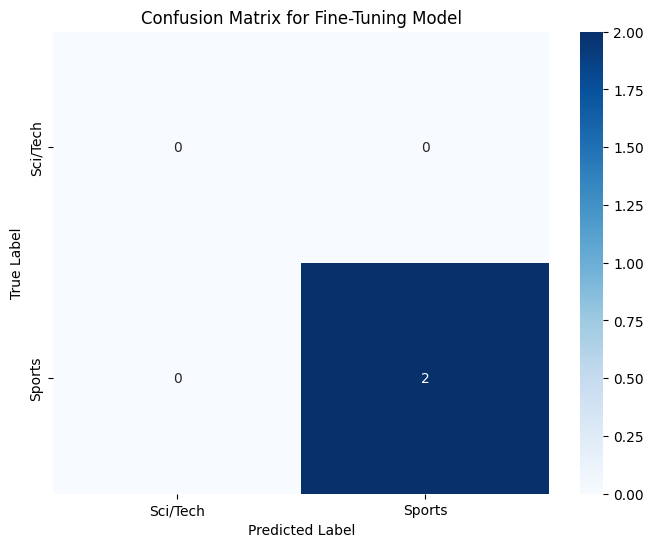

In [52]:
# Etiquetas verdaderas y predicciones del modelo de fine-tuning
true_labels = ['Sci/Tech', 'Sci/Tech', 'Sports', 'Sports']
predicted_labels = ['World', 'World', 'Sports', 'Sports']

# Crear la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=['Sci/Tech', 'Sports'])

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sci/Tech', 'Sports'], yticklabels=['Sci/Tech', 'Sports'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fine-Tuning Model')
plt.show()

## Classificacion Model

In [82]:
# Descargar el pipeline para clasificación de texto
turkish= pipeline(
    task="text-classification",
    model="serdarakyol/interpress-turkish-news-classification",
    device=0 if torch.cuda.is_available() else -1
)

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [83]:
# Definir los textos de prueba
texts = [

    """Researchers at MIT have developed a 
    new type of battery that could revolutionize the way we store energy. 
    Using a novel material that allows for faster charge times and longer battery 
    life, the team believes their invention could significantly impact the electric 
    vehicle market. The battery is also more environmentally friendly, using less
    rare metals and being easier to recycle.""",
    
    """NASA's James Webb Space Telescope has successfully 
    captured its first images of distant galaxies, revealing details never seen 
    before. The telescope's advanced infrared sensors allow scientists to peer 
    through cosmic dust and study the formation of stars and planets. This 
    groundbreaking technology is expected to provide new insights into the 
    origins of the universe and the potential for life on other planets.""",
    
    """In an exhilarating match last night, the Lakers secured a victory 
    against the Warriors with a final score of 112-109. LeBron James led the team 
    with an impressive 34 points, 8 rebounds, and 10 assists. The game was a 
    nail-biter until the very end, with both teams showcasing their skills 
    and determination. This win places the Lakers in a strong position for 
    the upcoming playoffs.""",
    
    """The Wimbledon tennis championship saw a stunning upset as an unseeded 
    player defeated the defending champion in straight sets. The match, held on 
    Centre Court, captivated audiences as the underdog displayed incredible agility 
    and precision. This unexpected victory has shaken up the tournament, 
    promising an exciting series of matches in the coming days."""
    
]


In [84]:
# Etiquetas esperadas para comparar precisión
expected_labels = ['Sci/Tech', 'Sci/Tech', 'Sports', 'Sports']

# Clasificar los textos
results = [turkish(text) for text in texts]

# Extraer las etiquetas predichas
predicted_labels = [result[0]['label'] for result in results]

# Definir el mapeo de etiquetas
label_map = {
    'Technology': 'Sci/Tech',
    'Sport': 'Sports'
}

# Mapear las etiquetas predichas a tus categorías
mapped_predicted_labels = [label_map.get(label, 'Unknown') for label in predicted_labels]

In [85]:
# Imprimir resultados
print(f"Mapped Predicted Label: {mapped_predicted_labels}")

Mapped Predicted Label: ['Sci/Tech', 'Sci/Tech', 'Sci/Tech', 'Sci/Tech']


### Analisis con Accuracy

In [86]:
# Evaluar precisión
accuracy = accuracy_score(expected_labels, mapped_predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.50


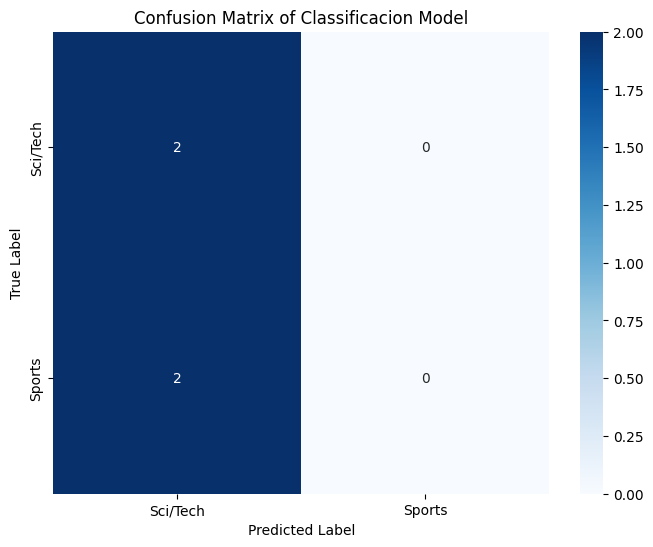

In [88]:
# Crear matriz de confusión
conf_matrix = confusion_matrix(expected_labels, mapped_predicted_labels, labels=['Sci/Tech', 'Sports'])

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sci/Tech', 'Sports'], yticklabels=['Sci/Tech', 'Sports'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Classificacion Model')
plt.show()

## Zero-Shot-Learning Classification

In [65]:
# Descargar el pipeline para clasificación de texto con zero-shot learning
zero_shot_classifier = pipeline("zero-shot-classification", 
                                model="sileod/deberta-v3-small-tasksource-nli")

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [66]:
# Definir los textos de prueba
texts = [
    """Researchers at MIT have developed a 
    new type of battery that could revolutionize the way we store energy. 
    Using a novel material that allows for faster charge times and longer battery 
    life, the team believes their invention could significantly impact the electric 
    vehicle market. The battery is also more environmentally friendly, using less
    rare metals and being easier to recycle.""",
    
    """NASA's James Webb Space Telescope has successfully 
    captured its first images of distant galaxies, revealing details never seen 
    before. The telescope's advanced infrared sensors allow scientists to peer 
    through cosmic dust and study the formation of stars and planets. This 
    groundbreaking technology is expected to provide new insights into the 
    origins of the universe and the potential for life on other planets.""",
    
    """In an exhilarating match last night, the Lakers secured a victory 
    against the Warriors with a final score of 112-109. LeBron James led the team 
    with an impressive 34 points, 8 rebounds, and 10 assists. The game was a 
    nail-biter until the very end, with both teams showcasing their skills 
    and determination. This win places the Lakers in a strong position for 
    the upcoming playoffs.""",
    
    """The Wimbledon tennis championship saw a stunning upset as an unseeded 
    player defeated the defending champion in straight sets. The match, held on 
    Centre Court, captivated audiences as the underdog displayed incredible agility 
    and precision. This unexpected victory has shaken up the tournament, 
    promising an exciting series of matches in the coming days."""
]


In [67]:
# Etiquetas esperadas
expected_labels = ['Sci/Tech', 'Sci/Tech', 'Sports', 'Sports']

# Clasificar los textos
results = [zero_shot_classifier(text, candidate_labels=['Sports', 'Sci/Tech']) for text in texts]

# Extraer las etiquetas predichas
predicted_labels = [result['labels'][0] for result in results]

# Verificar las etiquetas predichas
print("Raw Predicted Labels:", predicted_labels)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Raw Predicted Labels: ['Sci/Tech', 'Sci/Tech', 'Sports', 'Sports']


In [68]:
# Mapear las etiquetas predichas a tus categorías
label_map = {
    'Sci/Tech': 'Sci/Tech',
    'Sports': 'Sports'
}
mapped_predicted_labels = [label_map.get(label, 'Unknown') for label in predicted_labels]

In [69]:
# Imprimir resultados
print("Mapped Predicted Labels:", mapped_predicted_labels)

Mapped Predicted Labels: ['Sci/Tech', 'Sci/Tech', 'Sports', 'Sports']


### Analisis con Accuracy

In [43]:
# Evaluar precisión
accuracy = accuracy_score(expected_labels, mapped_predicted_labels)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


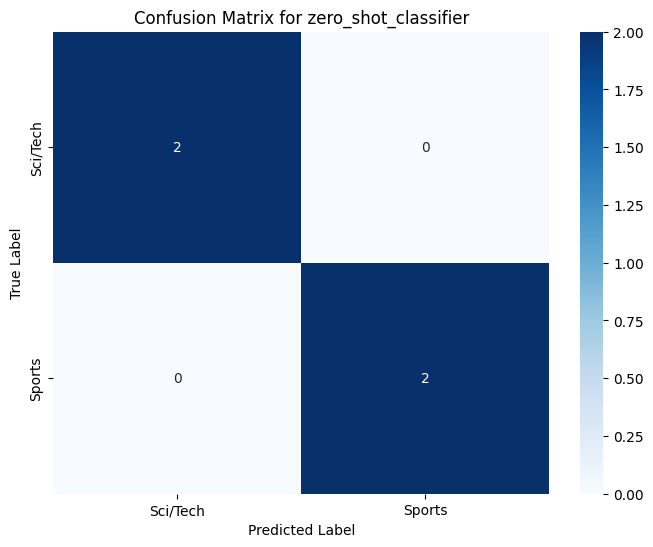

In [70]:
# Crear matriz de confusión
conf_matrix = confusion_matrix(expected_labels, mapped_predicted_labels, labels=['Sci/Tech', 'Sports'])

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sci/Tech', 'Sports'], yticklabels=['Sci/Tech', 'Sports'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for zero_shot_classifier')
plt.show()

## Few-Shot-Learning Classification

In [3]:
# Descargar el pipeline para clasificación de texto con zero-shot learning
few_shot_classifier = pipeline(
    model="sileod/deberta-v3-small-tasksource-nli"
)

C:\Users\micha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
# Definir ejemplos de pocos disparos (few-shot examples)
few_shot_examples = {
    "sports": [
        "The football match was exciting and full of energy.",
        "Basketball is a popular sport worldwide.",
        "The soccer team won the championship after a thrilling final."
    ],
    "sci/tech": [
        "The new study reveals important data about climate change.",
        "Quantum mechanics is a fundamental theory in physics.",
        "The research on genetic modification has made significant advances."
    ]
}

In [5]:
# Definir los textos de prueba
texts = [
    """Researchers at MIT have developed a 
    new type of battery that could revolutionize the way we store energy. 
    Using a novel material that allows for faster charge times and longer battery 
    life, the team believes their invention could significantly impact the electric 
    vehicle market. The battery is also more environmentally friendly, using less
    rare metals and being easier to recycle.""",
    
    """NASA's James Webb Space Telescope has successfully 
    captured its first images of distant galaxies, revealing details never seen 
    before. The telescope's advanced infrared sensors allow scientists to peer 
    through cosmic dust and study the formation of stars and planets. This 
    groundbreaking technology is expected to provide new insights into the 
    origins of the universe and the potential for life on other planets.""",
    
    """In an exhilarating match last night, the Lakers secured a victory 
    against the Warriors with a final score of 112-109. LeBron James led the team 
    with an impressive 34 points, 8 rebounds, and 10 assists. The game was a 
    nail-biter until the very end, with both teams showcasing their skills 
    and determination. This win places the Lakers in a strong position for 
    the upcoming playoffs.""",
    
    """The Wimbledon tennis championship saw a stunning upset as an unseeded 
    player defeated the defending champion in straight sets. The match, held on 
    Centre Court, captivated audiences as the underdog displayed incredible agility 
    and precision. This unexpected victory has shaken up the tournament, 
    promising an exciting series of matches in the coming days."""
]


In [6]:
# Etiquetas verdaderas para los textos
true_labels = ['Sci/Tech', 'Sci/Tech', 'Sports', 'Sports']

In [7]:
def classify_text_few_shot(text, examples):
    prompt = "Classify the following text into either 'sports' or 'sci/tech'.\n\n"
    for category, example_list in examples.items():
        prompt += f"{category} examples:\n"
        for example in example_list:
            prompt += f"- {example}\n"
    prompt += f"\nText to classify:\n{text}\n\nCategory:"
    
    # Clasificar el texto
    result = few_shot_classifier(prompt, candidate_labels=['sports', 'sci/tech'])
    return result['labels'][0]

In [8]:
# Clasificar los textos y guardar resultados
predicted_labels = [classify_text_few_shot(text, few_shot_examples) for text in texts]

# Verificar las etiquetas predichas
print("Predicted Labels:", predicted_labels)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Predicted Labels: ['sci/tech', 'sci/tech', 'sports', 'sports']


In [9]:
# Crear el mapeo de etiquetas
label_map = {
    'sci/tech': 'Sci/Tech',
    'sports': 'Sports'
}
mapped_predicted_labels = [label_map.get(label.lower(), 'Unknown') for label in predicted_labels]

In [10]:
# Imprimir resultados
print("Predicciones:", mapped_predicted_labels)

Predicciones: ['Sci/Tech', 'Sci/Tech', 'Sports', 'Sports']


### Analisis con Accuracy

In [11]:
# Evaluar precisión
accuracy = accuracy_score(true_labels, mapped_predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


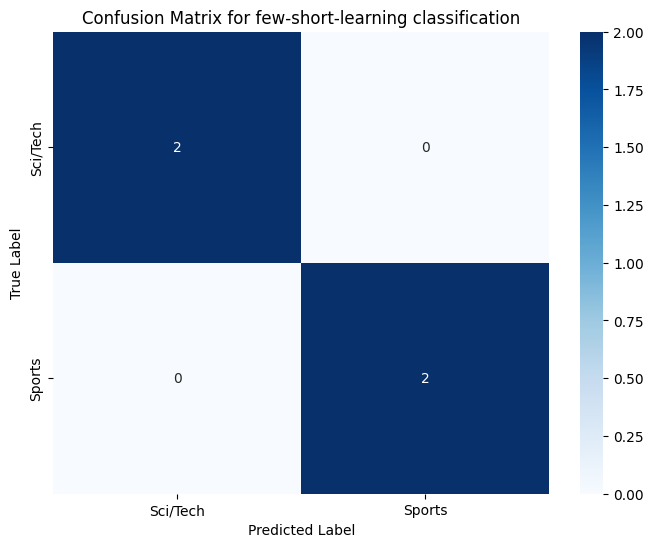

In [12]:
# Crear matriz de confusión
conf_matrix = confusion_matrix(true_labels, mapped_predicted_labels, labels=['Sci/Tech', 'Sports'])

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Sci/Tech', 'Sports'], yticklabels=['Sci/Tech', 'Sports'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for few-short-learning classification')
plt.show()